# Erstellen eines Prognosemodells des Kreditkartenzahlungsverkehrs für Online-Einkäufe

## Pakete importieren und Daten einlesen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [2]:
xl = pd.ExcelFile('PSP_Jan_Feb_2019.xlsx')
sheet_names = xl.sheet_names
df = xl.parse(sheet_names[0])
del df['Unnamed: 0']
df.head()

,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


## Daten erkunden

In [3]:
df.shape

(50410, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tmsp        50410 non-null  datetime64[ns]
 1   country     50410 non-null  object        
 2   amount      50410 non-null  int64         
 3   success     50410 non-null  int64         
 4   PSP         50410 non-null  object        
 5   3D_secured  50410 non-null  int64         
 6   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 2.7+ MB


In [5]:
df.columns

Index(['tmsp', 'country', 'amount', 'success', 'PSP', '3D_secured', 'card'], dtype='object')

## Gibt es fehlende Werte

In [6]:
missing_values = df.isnull().sum()
missing_values

tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64

## Überweisungsversuche, die zum selben Zahlungsversuch gehören, identifizieren

In [7]:
df = df.sort_values('tmsp')
df['transaction_id'] = -1
transaction_id = -1

for i in range(len(df)):
    if i > 0 and \
       (df.iloc[i]['country'] == df.iloc[i-1]['country']) and \
       (df.iloc[i]['amount'] == df.iloc[i-1]['amount']) and \
       ((df.iloc[i]['tmsp'] - df.iloc[i-1]['tmsp']).total_seconds() <= 5*60):
        df.at[i, 'transaction_id'] = df.at[i-1, 'transaction_id']
    else:
        transaction_id += 1
        df.at[i, 'transaction_id'] = transaction_id

In [8]:
df.head(25)

,tmsp,country,amount,success,PSP,3D_secured,card,transaction_id
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,1
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,1
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,2
5,2019-01-01 00:06:41,Switzerland,282,0,UK_Card,0,Master,3
6,2019-01-01 00:07:19,Switzerland,282,0,Simplecard,0,Master,3
7,2019-01-01 00:08:46,Germany,117,1,UK_Card,0,Master,4
8,2019-01-01 00:09:56,Switzerland,174,0,Simplecard,0,Visa,5
9,2019-01-01 00:10:49,Switzerland,174,0,Simplecard,0,Visa,5


## Anzahl der Zahlungsversuche berechnen

In [9]:
total_transactions = df['transaction_id'].nunique()
total_transactions

27298

## Wie viele Überweisungsversuche gab es pro Zahlungsversuch

In [10]:
attempts_per_transaction = df.groupby('transaction_id').size()
df['attempts'] = df['transaction_id'].map(attempts_per_transaction)

In [11]:
attempts_statistics = df['attempts'].describe()
attempts_statistics

count    50410.000000
mean         2.718508
std          1.785829
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         10.000000
Name: attempts, dtype: float64

In [12]:
max_attempts_rows = df[df['attempts'] == df['attempts'].max()]
max_attempts_rows

,tmsp,country,amount,success,PSP,3D_secured,card,transaction_id,attempts
14829,2019-01-17 00:03:10,Germany,240,0,Simplecard,1,Diners,7623,10
14830,2019-01-17 00:03:34,Germany,240,0,UK_Card,1,Diners,7623,10
14831,2019-01-17 00:04:28,Germany,240,0,Goldcard,1,Diners,7623,10
14832,2019-01-17 00:04:38,Germany,240,0,UK_Card,1,Diners,7623,10
14833,2019-01-17 00:05:16,Germany,240,0,Moneycard,1,Diners,7623,10
14834,2019-01-17 00:05:32,Germany,240,0,UK_Card,1,Diners,7623,10
14835,2019-01-17 00:05:53,Germany,240,0,UK_Card,1,Diners,7623,10
14836,2019-01-17 00:06:06,Germany,240,0,Simplecard,1,Diners,7623,10
14837,2019-01-17 00:06:27,Germany,240,0,Simplecard,1,Diners,7623,10
14838,2019-01-17 00:06:34,Germany,240,0,UK_Card,0,Master,7623,10


## Duplikate entfernen

In [13]:
duplicate_rows = df[df.duplicated(keep=False)]
duplicate_rows.head()

,tmsp,country,amount,success,PSP,3D_secured,card,transaction_id,attempts
84,2019-01-01 01:28:02,Germany,37,0,UK_Card,0,Master,33,6
83,2019-01-01 01:28:02,Germany,37,0,UK_Card,0,Master,33,6
495,2019-01-01 09:35:38,Germany,170,0,UK_Card,0,Diners,211,9
496,2019-01-01 09:35:38,Germany,170,0,UK_Card,0,Diners,211,9
499,2019-01-01 09:44:27,Germany,113,0,UK_Card,0,Visa,213,5


In [14]:
df = df.drop_duplicates()
df.shape

(50329, 9)

## Gesamt-Transaktionkosten berechnen

In [15]:
PSP_fees = {"Moneycard": [5, 2], "Goldcard": [10, 5], "UK_Card": [3, 1], "Simplecard": [1, 0.5]}

def calculate_costs(row):
    PSP = row['PSP']
    success = row['success']
    if PSP not in PSP_fees:
        return 0
    return PSP_fees[PSP][0] if success == 1 else PSP_fees[PSP][1]

df['costs'] = df.apply(calculate_costs, axis=1)

total_costs = df['costs'].sum()
total_costs

88463.5

## Erfolgsrate berechnen

In [16]:
success_rate = df['success'].mean() * 100
success_rate

20.32227940153788

## Zeitbasierte Merkmale generieren

In [17]:
df['minute'] = df['tmsp'].dt.minute
df['hour'] = df['tmsp'].dt.hour
df['weekday'] = df['tmsp'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

In [18]:
df.head(10)

,tmsp,country,amount,success,PSP,3D_secured,card,transaction_id,attempts,costs,minute,hour,weekday,is_weekend
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0,2,1.0,1,0,1,0
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0,2,3.0,1,0,1,0
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,1,2,1.0,2,0,1,0
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,1,2,3.0,3,0,1,0
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,2,1,0.5,4,0,1,0
5,2019-01-01 00:06:41,Switzerland,282,0,UK_Card,0,Master,3,2,1.0,6,0,1,0
6,2019-01-01 00:07:19,Switzerland,282,0,Simplecard,0,Master,3,2,0.5,7,0,1,0
7,2019-01-01 00:08:46,Germany,117,1,UK_Card,0,Master,4,1,3.0,8,0,1,0
8,2019-01-01 00:09:56,Switzerland,174,0,Simplecard,0,Visa,5,2,0.5,9,0,1,0
9,2019-01-01 00:10:49,Switzerland,174,0,Simplecard,0,Visa,5,2,0.5,10,0,1,0


## Kombinierte Merkmale generieren

In [19]:
df['country_PSP'] = df['country'] + "_" + df['PSP']
df['country_card'] = df['country'] + "_" + df['card']

## Statistische Werte berechnen

In [20]:
# Erfolgsraten
success_rate_country = df.groupby('country')['success'].mean()
success_rate_PSP = df.groupby('PSP')['success'].mean()
success_rate_card = df.groupby('card')['success'].mean()

# Durchschnittliche Kosten
avg_costs_country = df.groupby('country')['costs'].mean()
avg_costs_PSP = df.groupby('PSP')['costs'].mean()
avg_costs_card = df.groupby('card')['costs'].mean()

success_rate_country, success_rate_PSP, success_rate_card, avg_costs_country, avg_costs_PSP, avg_costs_card

(country
 Austria        0.204969
 Germany        0.201696
 Switzerland    0.206025
 Name: success, dtype: float64,
 PSP
 Goldcard      0.406172
 Moneycard     0.218833
 Simplecard    0.158212
 UK_Card       0.194861
 Name: success, dtype: float64,
 card
 Diners    0.223247
 Master    0.194252
 Visa      0.208756
 Name: success, dtype: float64,
 country
 Austria        1.747684
 Germany        1.753644
 Switzerland    1.779107
 Name: costs, dtype: float64,
 PSP
 Goldcard      7.030860
 Moneycard     2.656499
 Simplecard    0.579106
 UK_Card       1.389723
 Name: costs, dtype: float64,
 card
 Diners    1.823903
 Master    1.739455
 Visa      1.747592
 Name: costs, dtype: float64)

In [21]:
df.head()

,tmsp,country,amount,success,PSP,3D_secured,card,transaction_id,attempts,costs,minute,hour,weekday,is_weekend,country_PSP,country_card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0,2,1.0,1,0,1,0,Germany_UK_Card,Germany_Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0,2,3.0,1,0,1,0,Germany_UK_Card,Germany_Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,1,2,1.0,2,0,1,0,Germany_UK_Card,Germany_Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,1,2,3.0,3,0,1,0,Germany_UK_Card,Germany_Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,2,1,0.5,4,0,1,0,Austria_Simplecard,Austria_Diners


## Grafische Darstellung der Zusammenhänge

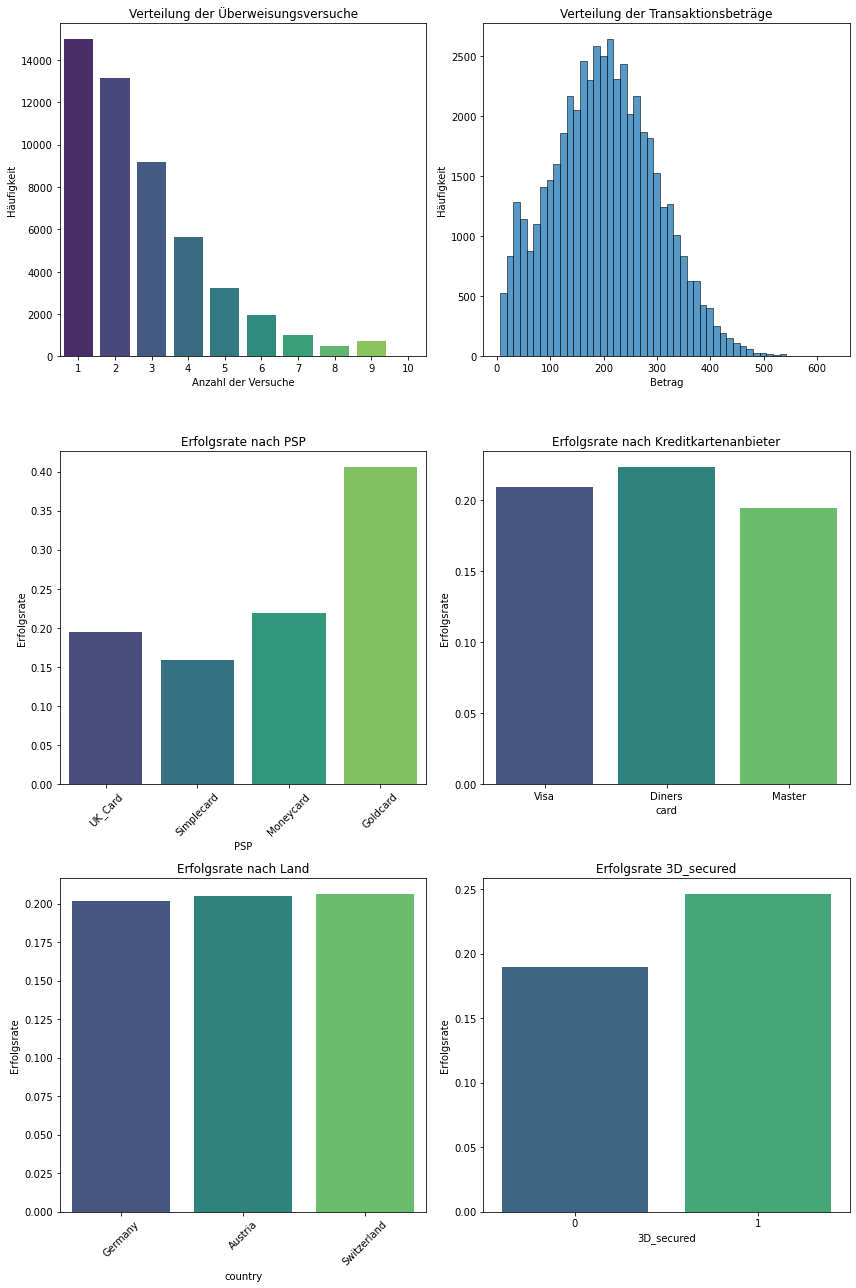

<Figure size 432x288 with 0 Axes>

In [22]:
plt.figure(figsize=(12, 18))

# Verteilung der Transaktionsbeträge
plt.subplot(3, 2, 2)
sns.histplot(df['amount'], kde=False, bins=50)
plt.title('Verteilung der Transaktionsbeträge')
plt.xlabel('Betrag')
plt.ylabel('Häufigkeit')

# Verteilung der Anzahl an Überweisungsversuchen
plt.subplot(3, 2, 1)
sns.countplot(x='attempts', data=df, palette="viridis")
plt.title('Verteilung der Überweisungsversuche')
plt.xlabel('Anzahl der Versuche')
plt.ylabel('Häufigkeit')

# Erfolgsrate nach PSP
plt.subplot(3, 2, 3)
sns.barplot(x='PSP', y='success', data=df, palette="viridis", ci=None)
plt.title('Erfolgsrate nach PSP')
plt.ylabel('Erfolgsrate')
plt.xticks(rotation=45)

# Erfolgsrate nach Kreditkartenanbieter
plt.subplot(3, 2, 4)
sns.barplot(x='card', y='success', data=df, palette="viridis", ci=None)
plt.title('Erfolgsrate nach Kreditkartenanbieter')
plt.ylabel('Erfolgsrate')

# Erfolgsrate nach Land
plt.subplot(3, 2, 5)
sns.barplot(x='country', y='success', data=df, palette="viridis", ci=None)
plt.title('Erfolgsrate nach Land')
plt.ylabel('Erfolgsrate')
plt.xticks(rotation=45)

# Erfolgsrate nach 3D_secured
plt.subplot(3, 2, 6)
sns.barplot(x='3D_secured', y='success', data=df, palette="viridis", ci=None)
plt.title('Erfolgsrate 3D_secured')
plt.xlabel('3D_secured')
plt.ylabel('Erfolgsrate')

plt.tight_layout()
plt.show()
plt.savefig("data_visualizations.png", dpi=300)

## Kategorische Merkmale mit OHE transformieren

In [23]:
categorical_columns = df.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df, columns=categorical_columns)
df_encoded.head()

,tmsp,amount,success,3D_secured,transaction_id,attempts,costs,minute,hour,weekday,...,country_PSP_Switzerland_UK_Card,country_card_Austria_Diners,country_card_Austria_Master,country_card_Austria_Visa,country_card_Germany_Diners,country_card_Germany_Master,country_card_Germany_Visa,country_card_Switzerland_Diners,country_card_Switzerland_Master,country_card_Switzerland_Visa
0,2019-01-01 00:01:11,89,0,0,0,2,1.0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
1,2019-01-01 00:01:17,89,1,0,0,2,3.0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2,2019-01-01 00:02:49,238,0,1,1,2,1.0,2,0,1,...,0,0,0,0,1,0,0,0,0,0
3,2019-01-01 00:03:13,238,1,1,1,2,3.0,3,0,1,...,0,0,0,0,1,0,0,0,0,0
4,2019-01-01 00:04:33,124,0,0,2,1,0.5,4,0,1,...,0,1,0,0,0,0,0,0,0,0


In [24]:
df_encoded.columns

Index(['tmsp', 'amount', 'success', '3D_secured', 'transaction_id', 'attempts',
       'costs', 'minute', 'hour', 'weekday', 'is_weekend', 'country_Austria',
       'country_Germany', 'country_Switzerland', 'PSP_Goldcard',
       'PSP_Moneycard', 'PSP_Simplecard', 'PSP_UK_Card', 'card_Diners',
       'card_Master', 'card_Visa', 'country_PSP_Austria_Goldcard',
       'country_PSP_Austria_Moneycard', 'country_PSP_Austria_Simplecard',
       'country_PSP_Austria_UK_Card', 'country_PSP_Germany_Goldcard',
       'country_PSP_Germany_Moneycard', 'country_PSP_Germany_Simplecard',
       'country_PSP_Germany_UK_Card', 'country_PSP_Switzerland_Goldcard',
       'country_PSP_Switzerland_Moneycard',
       'country_PSP_Switzerland_Simplecard', 'country_PSP_Switzerland_UK_Card',
       'country_card_Austria_Diners', 'country_card_Austria_Master',
       'country_card_Austria_Visa', 'country_card_Germany_Diners',
       'country_card_Germany_Master', 'country_card_Germany_Visa',
       'country_car

## DataFrame als Excel-Datei exportieren

In [25]:
df_encoded.to_excel("PSP_Jan_Feb_2019_cleaned.xlsx", index=False)

## Daten in Trainigs- und Testdaten aufteilen

In [26]:
X = df_encoded.drop(columns=['tmsp', 'success', 'transaction_id', 'attempts', 'costs'])
y = df_encoded['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40263, 37), (10066, 37), (40263,), (10066,))

## Baseline-Modell

In [27]:
y_pred_baseline = [1] * len(y_test)

accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
recall_baseline = recall_score(y_test, y_pred_baseline)
precision_baseline = precision_score(y_test, y_pred_baseline)
auc_baseline = roc_auc_score(y_test, y_pred_baseline)

accuracy_baseline, recall_baseline, precision_baseline, auc_baseline

(0.20325849393999604, 1.0, 0.20325849393999604, 0.5)

## Fortgeschrittenere Modelle trainieren und ROC-Kurven anzeigen

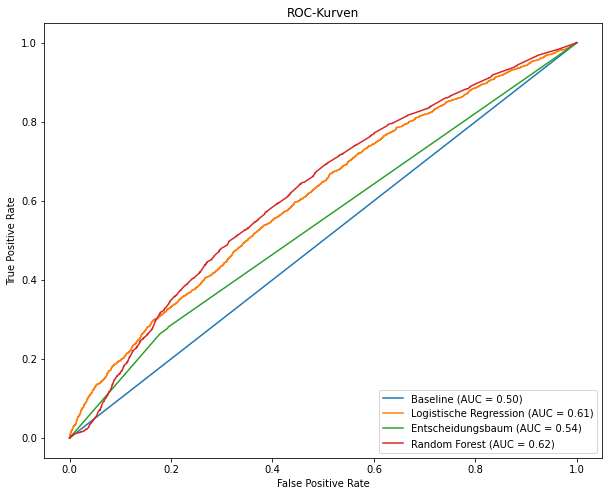

(0.7970395390423207,
 0.019550342130987292,
 0.5194805194805194,
 0.6086981958593253,
 0.708424398966819,
 0.26344086021505375,
 0.27402135231316727,
 0.5437384056964139,
 0.7589906616332207,
 0.10997067448680352,
 0.2710843373493976,
 0.6204525952957294)

In [28]:
# Modelle initialisieren
logreg = LogisticRegression(max_iter=10000, random_state=42)
dtree = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

# Modelle trainieren
logreg.fit(X_train, y_train)
dtree.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Vorhersagen für den Test-Datensatz
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]
y_prob_dtree = dtree.predict_proba(X_test)[:, 1]
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Performance-Metriken berechnen
accuracy_logreg = accuracy_score(y_test, logreg.predict(X_test))
recall_logreg = recall_score(y_test, logreg.predict(X_test))
precision_logreg = precision_score(y_test, logreg.predict(X_test))
auc_logreg = roc_auc_score(y_test, y_prob_logreg)

accuracy_dtree = accuracy_score(y_test, dtree.predict(X_test))
recall_dtree = recall_score(y_test, dtree.predict(X_test))
precision_dtree = precision_score(y_test, dtree.predict(X_test))
auc_dtree = roc_auc_score(y_test, y_prob_dtree)

accuracy_rf = accuracy_score(y_test, rf.predict(X_test))
recall_rf = recall_score(y_test, rf.predict(X_test))
precision_rf = precision_score(y_test, rf.predict(X_test))
auc_rf = roc_auc_score(y_test, y_prob_rf)

# ROC-Kurven zeichnen
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_baseline)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_prob_logreg)
fpr_dtree, tpr_dtree, _ = roc_curve(y_test, y_prob_dtree)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(10, 8))
plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC = {auc_baseline:.2f})')
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistische Regression (AUC = {auc_logreg:.2f})')
plt.plot(fpr_dtree, tpr_dtree, label=f'Entscheidungsbaum (AUC = {auc_dtree:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurven')
plt.legend(loc='lower right')
plt.show()

accuracy_logreg, recall_logreg, precision_logreg, auc_logreg, accuracy_dtree, recall_dtree, precision_dtree, auc_dtree, accuracy_rf, recall_rf, precision_rf, auc_rf

In [29]:
performance_data = {"Model": ["Baseline", "Logistische Regression", "Entscheidungsbaum", "Random Forest"],
    "Accuracy": [accuracy_baseline, accuracy_logreg, accuracy_dtree, accuracy_rf],
    "Recall": [recall_baseline, recall_logreg, recall_dtree, recall_rf],
    "Precision": [precision_baseline, precision_logreg, precision_dtree, precision_rf],
    "AUC-Score": [auc_baseline, auc_logreg, auc_dtree, auc_rf]}

performance_table = pd.DataFrame(performance_data)
performance_table

,Model,Accuracy,Recall,Precision,AUC-Score
0,Baseline,0.203258,1.000000,0.203258,0.500000
1,Logistische Regression,0.797040,0.019550,0.519481,0.608698
2,Entscheidungsbaum,0.708424,0.263441,0.274021,0.543738
3,Random Forest,0.758991,0.109971,0.271084,0.620453


## Random-Forest-Modell näher beleuchten

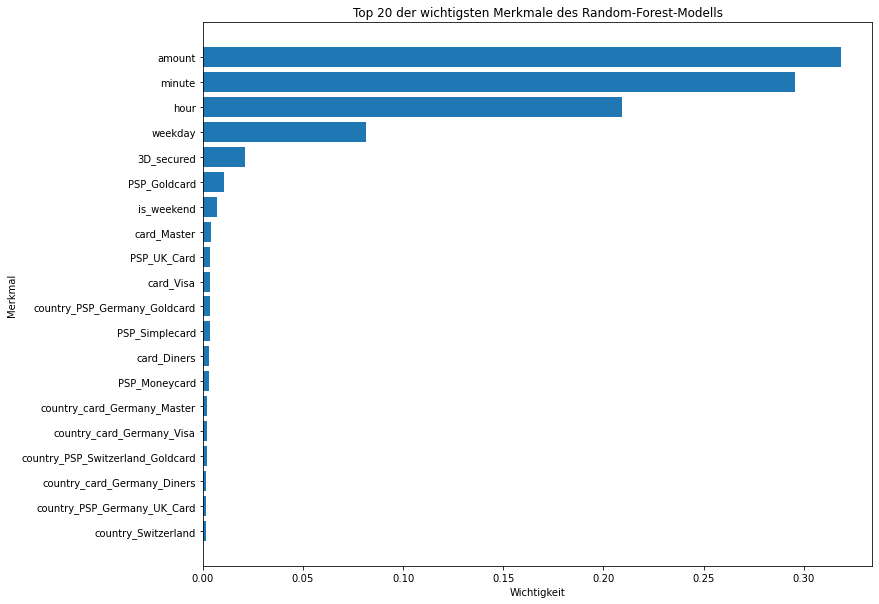

,Feature,Importance
0,amount,0.318408
2,minute,0.295680
3,hour,0.209475
4,weekday,0.081591
1,3D_secured,0.020912
9,PSP_Goldcard,0.010634
5,is_weekend,0.007217
14,card_Master,0.003876
12,PSP_UK_Card,0.003740
15,card_Visa,0.003455


In [30]:
feature_importance = rf.feature_importances_
feature_names = X_train.columns

feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 10))
plt.barh(feature_df['Feature'][:20], feature_df['Importance'][:20], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Wichtigkeit')
plt.ylabel('Merkmal')
plt.title('Top 20 der wichtigsten Merkmale des Random-Forest-Modells')
plt.show()

feature_df[:20]

## Weglassen von weniger wichtigen Merkmalen testen

In [31]:
sorted_importance = feature_df.sort_values(by='Importance', ascending=True)
median_importance = feature_df['Importance'].median()
mean_importance = feature_df['Importance'].mean()

median_importance, mean_importance

(0.0015736050738432933, 0.027027027027027025)

In [32]:
selected_features = feature_df[feature_df['Importance'] > median_importance]['Feature'].tolist()

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

rf_selected = RandomForestClassifier(random_state=42)
rf_selected.fit(X_train_selected, y_train)

accuracy_selected = accuracy_score(y_test, rf_selected.predict(X_test_selected))
recall_selected = recall_score(y_test, rf_selected.predict(X_test_selected))
precision_selected = precision_score(y_test, rf_selected.predict(X_test_selected))
auc_selected = roc_auc_score(y_test, rf_selected.predict_proba(X_test_selected)[:, 1])

accuracy_selected, recall_selected, precision_selected, auc_selected

(0.7589906616332207,
 0.09237536656891496,
 0.24934036939313983,
 0.6206322841478903)

## Verschiedene Hyperparameter mit randomisierter Suche testen

In [33]:
param_dist = {
    'n_estimators': np.arange(50, 501, 50),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': np.arange(3, 21, 2).tolist() + [None],
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, scoring='roc_auc', cv=3, 
                                   verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_params

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

{'n_estimators': 200,
 'min_samples_split': 6,
 'min_samples_leaf': 8,
 'max_features': 'auto',
 'max_depth': 9,
 'bootstrap': False}

## Random-Forest-Modell mit den besten Parametern trainieren und ROC-Kurve zeigen

In [34]:
rf_best_params = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=6,
    min_samples_leaf=8,
    max_features='auto',
    max_depth=9,
    bootstrap=False,
    random_state=42
)

rf_best_params.fit(X_train, y_train)

accuracy_best_params = accuracy_score(y_test, rf_best_params.predict(X_test))
recall_best_params = recall_score(y_test, rf_best_params.predict(X_test))
precision_best_params = precision_score(y_test, rf_best_params.predict(X_test))
auc_best_params = roc_auc_score(y_test, rf_best_params.predict_proba(X_test)[:, 1])

accuracy_best_params, recall_best_params, precision_best_params, auc_best_params

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


(0.7989270812636599,
 0.03128054740957967,
 0.6037735849056604,
 0.6605053531859502)

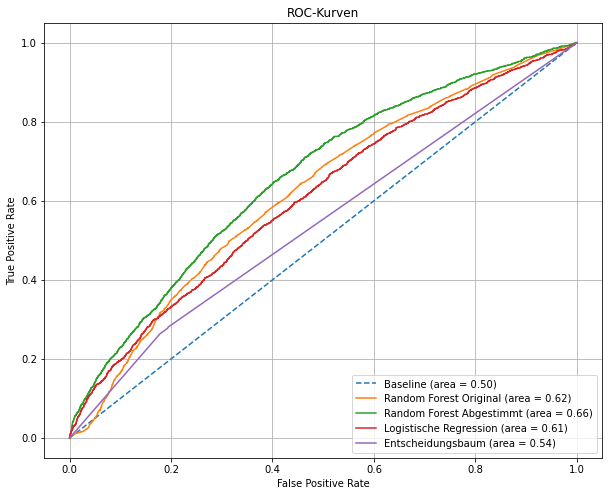

In [35]:
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, [1]*len(y_test))
fpr_rf_original, tpr_rf_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
fpr_rf_best_params, tpr_rf_best_params, _ = roc_curve(y_test, rf_best_params.predict_proba(X_test)[:, 1])
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
fpr_dtree, tpr_dtree, _ = roc_curve(y_test, dtree.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 8))
plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline (area = {auc_baseline:.2f})', linestyle='--')
plt.plot(fpr_rf_original, tpr_rf_original, label=f'Random Forest Original (area = {auc_rf:.2f})')
plt.plot(fpr_rf_best_params, tpr_rf_best_params, label=f'Random Forest Abgestimmt (area = {auc_best_params:.2f})')
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistische Regression (area = {auc_logreg:.2f})')
plt.plot(fpr_dtree, tpr_dtree, label=f'Entscheidungsbaum (area = {auc_dtree:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurven')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## SMOTE-Rebalancing testen

In [36]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

rf_best_params_resampled = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=6,
    min_samples_leaf=8,
    max_features='auto',
    max_depth=9,
    bootstrap=False,
    random_state=42
)
rf_best_params_resampled.fit(X_train_resampled, y_train_resampled)

accuracy_resampled = accuracy_score(y_test, rf_best_params_resampled.predict(X_test))
recall_resampled = recall_score(y_test, rf_best_params_resampled.predict(X_test))
precision_resampled = precision_score(y_test, rf_best_params_resampled.predict(X_test))
auc_resampled = roc_auc_score(y_test, rf_best_params_resampled.predict_proba(X_test)[:, 1])

print("Accuracy:", accuracy_resampled)
print("Recall:", recall_resampled)
print("Precision:", precision_resampled)
print("AUC:", auc_resampled)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy: 0.7874031392807471
Recall: 0.1158357771260997
Precision: 0.41725352112676056
AUC: 0.6457868037628315


## Zusammenhänge zwischen den wichtigsten Merkmalen und Erfolg darstellen

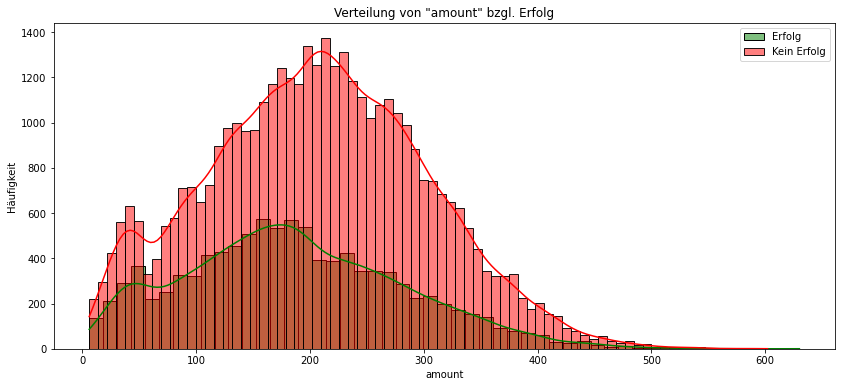

In [37]:
plt.figure(figsize=(14, 6))
sns.histplot(df_encoded[df_encoded['success'] == 1]['amount'], color='green', kde=True, label='Erfolg')
sns.histplot(df_encoded[df_encoded['success'] == 0]['amount'], color='red', kde=True, label='Kein Erfolg', alpha=0.5)
plt.title('Verteilung von "amount" bzgl. Erfolg')
plt.xlabel('amount')
plt.ylabel('Häufigkeit')
plt.legend()
plt.show()

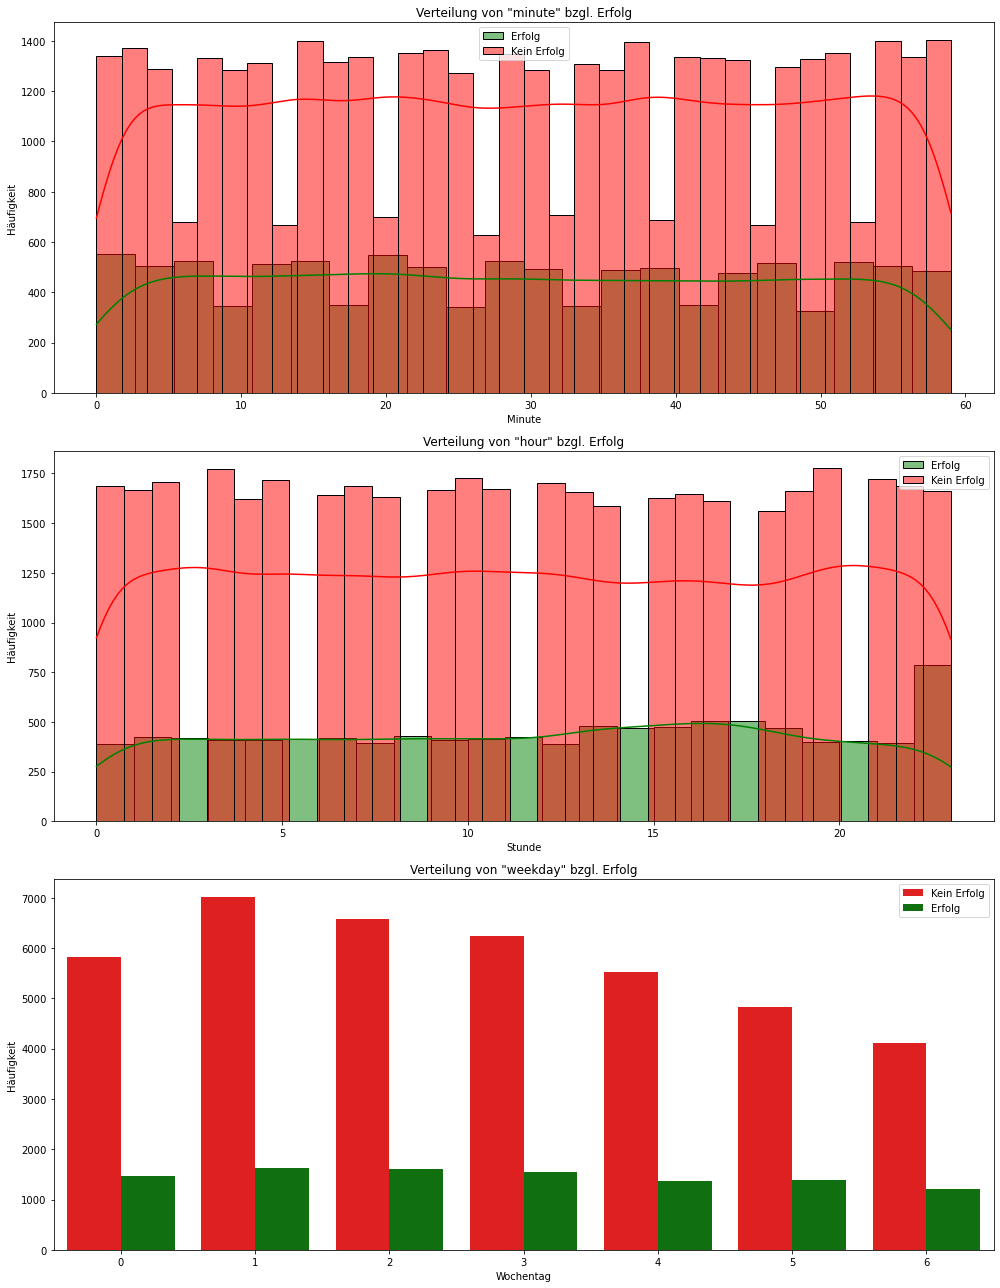

In [38]:
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

sns.histplot(df_encoded[df_encoded['success'] == 1]['minute'], color='green', kde=True, ax=axes[0], label='Erfolg')
sns.histplot(df_encoded[df_encoded['success'] == 0]['minute'], color='red', kde=True, ax=axes[0], label='Kein Erfolg', alpha=0.5)
axes[0].set_title('Verteilung von "minute" bzgl. Erfolg')
axes[0].set_xlabel('Minute')
axes[0].set_ylabel('Häufigkeit')
axes[0].legend()

sns.histplot(df_encoded[df_encoded['success'] == 1]['hour'], color='green', kde=True, ax=axes[1], label='Erfolg')
sns.histplot(df_encoded[df_encoded['success'] == 0]['hour'], color='red', kde=True, ax=axes[1], label='Kein Erfolg', alpha=0.5)
axes[1].set_title('Verteilung von "hour" bzgl. Erfolg')
axes[1].set_xlabel('Stunde')
axes[1].set_ylabel('Häufigkeit')
axes[1].legend()

sns.countplot(data=df_encoded, x='weekday', hue='success', ax=axes[2], palette=['red', 'green'])
axes[2].set_title('Verteilung von "weekday" bzgl. Erfolg')
axes[2].set_xlabel('Wochentag')
axes[2].set_ylabel('Häufigkeit')
axes[2].legend(labels=['Kein Erfolg', 'Erfolg'])

plt.tight_layout()
plt.show()

## Für jeden PSP eigenes Modell erstellen, das die Erfolgswahrscheinlichkeit berechnet
(Mit den gleichen Hyperparametern)

In [39]:
df_encoded['psp_id'] = 0
df_encoded.loc[df_encoded['PSP_Goldcard'] == 1, 'psp_id'] = 1
df_encoded.loc[df_encoded['PSP_Moneycard'] == 1, 'psp_id'] = 2
df_encoded.loc[df_encoded['PSP_Simplecard'] == 1, 'psp_id'] = 3
df_encoded.loc[df_encoded['PSP_UK_Card'] == 1, 'psp_id'] = 4

df_encoded['psp_id'].value_counts()

4    26388
3    12439
2     8294
1     3208
Name: psp_id, dtype: int64

In [40]:
psp_models = {}

for psp in df_encoded['psp_id'].unique():
    df_psp = df_encoded[df_encoded['psp_id'] == psp]
    X_psp = df_psp.drop(columns=['tmsp', 'success', 'transaction_id', 'attempts', 'costs', 'psp_id'])
    y_psp = df_psp['success']
    
    X_train_psp, X_test_psp, y_train_psp, y_test_psp = train_test_split(X_psp, y_psp, test_size=0.2, stratify=y_psp, random_state=42)
    
    rf_psp = RandomForestClassifier(
        n_estimators=200,
        min_samples_split=6,
        min_samples_leaf=8,
        max_features='auto',
        max_depth=9,
        bootstrap=False,
        random_state=42
    )
    rf_psp.fit(X_train_psp, y_train_psp)
    
    psp_models[psp] = rf_psp

len(psp_models)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

4

In [41]:
def predict_psp_probabilities(transaction_data):
    psp_id_to_name = {
        1: 'PSP_Goldcard',
        2: 'PSP_Moneycard',
        3: 'PSP_Simplecard',
        4: 'PSP_UK_Card'
    }
    
    psp_probabilities = {}
    
    for psp, model in psp_models.items():
        # Vorhersagewahrscheinlichkeit für den aktuellen PSP berechnen
        prob = model.predict_proba(transaction_data.values.reshape(1, -1))[:, 1][0]
        
        # Wahrscheinlichkeit im Dictionary speichern
        psp_name = psp_id_to_name[psp]
        psp_probabilities[psp_name] = prob
    
    return psp_probabilities

## Funktion testen

In [42]:
sample_transaction = X_test.sample(1)
predict_psp_probabilities(sample_transaction.iloc[0])

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


{'PSP_UK_Card': 0.2360342432437164,
 'PSP_Simplecard': 0.10454118042234707,
 'PSP_Moneycard': 0.154649301019131,
 'PSP_Goldcard': 0.4836729633783677}

In [43]:
# Beispielhafter Ansatz:

psp_models = {}
unique_psps = df['PSP'].unique()

for psp in unique_psps:
    psp_data = df_encoded[df['PSP'] == psp]
    X_psp = psp_data.drop(columns=['tmsp', 'success', 'transaction_id'])
    y_psp = psp_data['success']
    
    clf_psp = DecisionTreeClassifier(random_state=42)
    clf_psp.fit(X_psp, y_psp)
    
    psp_models[psp] = clf_psp

def predict_best_psp(input_data):
    probabilities = {}
    for psp, model in psp_models.items():
        proba = model.predict_proba(input_data)[:, 1][0]
        probabilities[psp] = proba

    best_psp = max(probabilities, key=probabilities.get)
    return best_psp, probabilities[best_psp]

sample_data = X_test.iloc[0:1]
predicted_psp, predicted_proba = predict_best_psp(sample_data)

predicted_psp, predicted_proba

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- attempts
- costs
- psp_id

  warnings.warn(message, FutureWarning)


ValueError: X has 37 features, but DecisionTreeClassifier is expecting 40 features as input.